In [170]:
from matplotlib import pyplot as plt
from scipy.stats import beta
import numpy as np
from scipy.stats import beta, gamma
np.random.seed(42)  # 设置随机种子以确保可重复性

# SIRS模型的导数
def sirs_derivatives(state, beta, gamma, xi, N):
    S, I, R = state
    dS = -beta * S * I / N + xi * R
    dI = beta * S * I / N - gamma * I
    dR = gamma * I - xi * R
    new_infections_rate = beta * S * I / N  # 新增感染率（不含康复项）
    return np.array([dS, dI, dR]), new_infections_rate


# RK4方法
def rk4_step(state, beta, gamma, xi, N, dt):
    total_infected = 0
    current_state = state.copy()

    for day in range(7):
        # RK4步骤：计算斜率和新增感染率
        k1, new_inf1 = sirs_derivatives(current_state, beta, gamma, xi, N)
        k2, new_inf2 = sirs_derivatives(current_state + 0.5 * dt * k1, beta, gamma, xi, N)
        k3, new_inf3 = sirs_derivatives(current_state + 0.5 * dt * k2, beta, gamma, xi, N)
        k4, new_inf4 = sirs_derivatives(current_state + dt * k3, beta, gamma, xi, N)

        # 累计感染数（RK4加权平均）
        avg_new_inf = (new_inf1 + 2 * new_inf2 + 2 * new_inf3 + new_inf4) / 6.0
        total_infected += avg_new_inf * dt

        # 更新状态
        current_state = current_state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        current_state = np.clip(current_state, 0, N)

    return current_state, total_infected


def forecast_ILI(state, beta, gamma, xi, N, dt, steps=8):
    """预测未来steps周的ILI"""
    current_state = state.copy()
    ILI_pred = np.zeros(steps)
    for s in range(steps):
        current_state, total_infected = rk4_step(current_state, beta, gamma, xi, N, dt)
        ILI_pred[s] = total_infected
        current_state = np.clip(current_state, 0, N)
    return ILI_pred


def nonlinear_scale(ili, base_scale=0.001, max_scale=0.06):
    return base_scale + (max_scale - base_scale) * (1 / (1 + np.exp(-100 * (ili - 0.075))))


def cal_upp(t, k, N):
    print(t, k, N)
    lower = beta.ppf(0.25, k*(t / N), k * (1 - t / N)) * N
    upper = beta.ppf(0.75, k*(t / N), k * (1 - t / N)) * N
    return lower,upper


def particle_filter(data, holiday_effect, num_particles, N, beta_prior, gamma_prior, xi_prior, k, dt=1.0,
                    param_noise=0.001, ess_threshold=0.1, state_noise=100.0, beta_dynamics_scale=0.1):
    """
    使用粒子滤波拟合SIRS模型（RK4更新，动态参数，改进的退化修复）
    新增：为beta添加动态更新模型
    参数：
        data: 观测数据（ILI+比例）
        num_particles: 粒子数量
        N: 总人口
        beta_prior, gamma_prior, xi_prior: 参数先验分布参数
        k: Beta分布的尺度参数
        dt: 时间步长
        param_noise: 参数扰动的标准差
        ess_threshold: 有效粒子数比例阈值（触发重新初始化）
        state_noise: 状态扰动标准差（用于重新初始化）
        beta_dynamics_scale: beta动态更新的标准差（控制beta变化幅度）
    返回：估计的状态和参数
    """
    global error
    report_rate = 0.8
    T = len(data)
    particles = np.zeros((num_particles, 3))  # [S, I, R]
    params = np.zeros((num_particles, 3))  # [beta, gamma, xi]
    weights = np.ones(num_particles) / num_particles
    ILI_est = np.zeros((num_particles, 1))  # [beta, gamma, xi]

    # 初始化粒子
    particles[:, 0] = N * 0.7
    particles[:, 1] = N*0.1 # 初始感染者
    particles[:, 2] = N * 0.2  # 初始恢复者
    params[:, 0] = np.random.uniform(beta_prior[0], beta_prior[1], size=num_particles)
    params[:, 1] = np.random.uniform(gamma_prior[0], gamma_prior[1], size=num_particles)
    params[:, 2] = np.random.uniform(xi_prior[0], xi_prior[1], size=num_particles)

    # 保存估计结果
    state_estimates = np.zeros((T, 3))
    param_estimates = np.zeros((T, 3))
    ILI_estimates = np.zeros(T)
    ess_history = np.zeros(T)  # 记录ESS
    ILI_forecasts = np.zeros((T, 8))
    ILI_forecasts_new = np.zeros((T, 8))

    # 历史窗口
    window_size = 3
    data_window = np.zeros(window_size)
    w = []

    for t in range(T):
        trend = 0
        if data[t] == 0:
            data[t] = 1e-5
            # 更新历史窗口
        if t < window_size:
            data_window[t] = data[t]
        else:
            data_window = np.roll(data_window, -1)
            data_window[-1] = data[t]

        base_beta_dynamics_scale = nonlinear_scale(data[t] / 19000)
        holiday_effect_current = holiday_effect[t]

        for i in range(num_particles):
            # 更新状态
            particles[i], total_infected = rk4_step(particles[i], params[i, 0], params[i, 1], params[i, 2], N, dt)
            # TODO total_infected 和去就诊的人数还存在一定的比例，高峰期去就诊的人不一定多吧。
            # 添加状态过程噪声
            I_prop = total_infected / N
            error = data[t] - I_prop
            adaptive_noise = 10 + abs(error) / 100  # 基础噪声 + 偏差驱动
            particles[i] += np.random.normal(0, adaptive_noise, 3)
            particles[i] = np.clip(particles[i], 0, N)
            total = np.sum(particles[i])
            if total > 0:
                particles[i] *= N / total  # 保持总数不变

            if error > 200 and data[t] < 1000:
                trend_start = 0.01
            else:
                trend_start = 0

            if abs(error) > 250:
                fix = 0.01
            else:
                fix = 0

            beta_dynamics_scale = 0.005 + trend_start + fix
            params[i, 0] += np.random.normal(0, beta_dynamics_scale)  # beta的动态变化
            params[i, 0] = np.clip(params[i, 0], beta_prior[0], beta_prior[1])  # 限制在先验范围内

            # 添加其他参数扰动（gamma, xi）
            params[i, 1:] += np.random.normal(0, param_noise, 2)
            params[i] = np.clip(params[i], 0, None)  # 确保参数非负
            # particles[i], total_infected = rk4_step(particles[i], params[i, 0], params[i, 1], params[i, 2], N, dt)


            # 更新权重
            I_prop = (total_infected / N)*report_rate # 感染比例
            adjust_k = k - holiday_effect_current * 350
            if holiday_effect_current > 0 :
                alpha = adjust_k * I_prop
                beta_param = adjust_k * (1 - I_prop)
            else:
                alpha = k * I_prop
                beta_param = k * (1 - I_prop)
            ILI_est[i] = total_infected*report_rate
            likelihood = beta.pdf(data[t] / N, alpha, beta_param)
            likelihood = max(likelihood, 1e-6)  # 防止概率为0
            weights[i] *= likelihood if likelihood > 0 else 1e-10

        # 归一化权重
        w.append(weights)
        weights /= np.sum(weights)
        # 计算有效粒子数（ESS）
        ess = 1.0 / np.sum(weights ** 2) / num_particles
        ess_history[t] = ess

        # 检测退化并重新初始化
        if ess < ess_threshold:
            print(f"Time {t}: ESS ({ess:.3f}) below threshold ({ess_threshold}), reinitializing...")
            # 重新初始化参数
            beta_mean = np.sum(params[:, 0] * weights)
            params[:, 0] = np.random.normal(beta_mean, 0.1, num_particles)
            params[:, 0] = np.clip(params[:, 0], beta_prior[0], beta_prior[1])

            # 扰动当前状态估计
            current_state = state_estimates[t - 1] if t > 0 else np.array([N - 100, 100, 0])
            l, u = cal_upp(data[t - 1], k, N)
            if ILI_estimates[t - 1] > u:
                current_state[0] = current_state[0] * 0.9
            elif ILI_estimates[t - 1] < l:
                current_state[0] = current_state[0] * 1.1

            for i in range(num_particles):
                particles[i], total_infected = rk4_step(current_state, params[i, 0], params[i, 1], params[i, 2], N, dt)
                particles[i] = np.clip(particles[i], 0, N)
                # 确保 S + I + R ≈ N
                total = np.sum(particles[i])
                if total > 0:
                    particles[i] *= N/total
                # 更新权重
                I_prop = (total_infected / N)*report_rate  # 感染比例

                adjust_k = k - holiday_effect_current * 350
                if holiday_effect_current > 0 and error < -200:
                    alpha = adjust_k * I_prop
                    beta_param = adjust_k * (1 - I_prop)
                else:
                    alpha = k * I_prop
                    beta_param = k * (1 - I_prop)
                ILI_est[i] = total_infected*report_rate
                likelihood = beta.pdf(data[t] / N, alpha, beta_param)
                weights[i] = likelihood if likelihood > 0 else 1e-10

            weights /= np.sum(weights)
            ess = 1.0 / np.sum(weights ** 2) / num_particles
            ess_history[t] = ess

        # particle_forecasts = np.zeros((num_particles, 8))  # 存储每个粒子的预测轨迹
        # for i in range(num_particles):
        #     particle_state = particles[i]  # 第 i 个粒子的状态 (S, I, R)
        #     particle_params = params[i]    # 第 i 个粒子的参数 (beta, gamma, mu)
            
        #     # 调用 forecast_ILI 函数，传入单个粒子的状态和参数
        #     particle_forecasts[i] = forecast_ILI(
        #         particle_state,           # 单个粒子的状态
        #         particle_params[0],       # beta
        #         particle_params[1],       # gamma
        #         particle_params[2],       # mu
        #         N,                        # 总人口
        #         dt,                       # 时间步长
        #         steps=8       # 预测步数
        #     )
        # ILI_forecasts_new[t] = np.average(particle_forecasts, axis=0, weights=weights)


        # 估计当前状态和参数
        state_estimates[t] = np.average(particles, axis=0, weights=weights)
        ILI_estimates[t] = np.average(ILI_est, axis=0, weights=weights)
        param_estimates[t] = np.average(params, axis=0, weights=weights)

    
        ILI_forecasts[t] = forecast_ILI(
            state_estimates[t],
            param_estimates[t, 0],
            param_estimates[t, 1],
            param_estimates[t, 2],
            N,
            dt,
            steps=8
        )
        print("t:", t, "state:", state_estimates[t], "ILI:", ILI_estimates[t], 'param:', param_estimates[t], 'ess:',
              ess)
        
        # 重采样
        cumsum = np.cumsum(weights)
        u0 = np.random.uniform(0, 1 / num_particles)
        u = u0 + np.arange(num_particles) / num_particles
        indices = np.searchsorted(cumsum, u)

        particles = particles[indices]
        params = params[indices]
        weights = np.ones(num_particles) / num_particles

    return state_estimates, param_estimates, ess_history, ILI_estimates, ILI_forecasts, w


def visualize_ili_forecast(obs_data, ILI_estimates, ILI_forecasts, week_to_plot, N):
    """
    可视化粒子滤波的ILI预测，突出显示指定周的8周预测
    参数：
        obs_data: 观测数据（ILI比例）
        ILI_estimates: 估计的ILI（感染人数）
        ILI_forecasts: 未来8周的ILI预测，形状为(T, 8)
        week_to_plot: 要可视化的预测起始周（0-based index）
        N: 总人口
    返回：
        保存的图形文件
    """
    T = len(obs_data)
    # 确保week_to_plot有效
    if week_to_plot < 0 or week_to_plot >= T:
        raise ValueError(f"week_to_plot must be between 0 and {T - 1}, got {week_to_plot}")

    # 创建图形
    plt.figure(figsize=(8, 4))

    # 绘制观测数据
    plt.plot(np.arange(T), obs_data, 'b-', label='Observed ILI', linewidth=2)

    # 绘制估计的ILI（转换为比例）
    plt.plot(np.arange(T), ILI_estimates, 'r--', label='Estimated ILI', linewidth=2)

    # 绘制指定周的8周预测
    forecast_times = np.arange(week_to_plot+1, week_to_plot+1 + 8)
    forecast_values = ILI_forecasts[week_to_plot]
    plt.plot(forecast_times, forecast_values, 'g-', label=f'Forecast from week {week_to_plot}', linewidth=2, marker='o')

    # 设置图形属性
    plt.xlabel('Week')
    plt.ylabel('ILI Proportion')
    plt.title(f'ILI Forecast from Week {week_to_plot}')
    plt.grid(True)
    plt.legend()

    # 保存图形
    plt.show()


def visualize_state_estimates(state_estimates, N, save_path='state_estimates_plot.png'):
    T = state_estimates.shape[0]
    time_steps = np.arange(T)

    # 提取S, I, R
    S = state_estimates[:, 0]
    I = state_estimates[:, 1]
    R = state_estimates[:, 2]
    # 创建图形
    plt.figure(figsize=(8, 5))

    # 绘制S, I, R（比例）
    plt.subplot(2, 1, 2)
    plt.plot(time_steps, S, 'b-', label='beta', linewidth=2)
    plt.plot(time_steps, I, 'r-', label='gamma', linewidth=2)
    plt.plot(time_steps, R, 'g-', label='xi', linewidth=2)
    plt.xlabel('Week')
    plt.ylabel('Proportion')
    plt.title('param Estimates (Proportions) Over Time')
    plt.grid(True)
    # plt.legend()

    # 调整布局
    plt.tight_layout()
    # plt.savefig('beta_particle_filter.png', dpi=300, bbox_inches='tight')  # 保存为 PNG

    # 保存图形
    plt.show()

In [171]:
import pandas as pd
import pickle



data = pd.read_csv('../data/flu_data_7.csv')
# obs = data['% WEIGHTED ILI']*data['pos']*10
obs = data['ILI+']
data['holiday_effect'] = 0
obs = obs.values
obs_data = obs*100
obs_data = obs_data#[0:100]
holiday_effect = data['holiday_effect'].values#[0:100]

In [172]:
N = 100000 # 总人口
k = 1000    # Beta分布尺度参数
dt = 1.0   # 时间步长

# 运行粒子滤波
num_particles = 1000
beta_prior = (0, 0.6)   # Gamma分布参数 (shape, rate)
gamma_prior = (0.245, 0.255)
xi_prior = (0.005, 0.006)    # xi的先验
param_noise = 0.00001    # 参数扰动标准差
ess_threshold = 0.3   # ESS阈值（占总粒子数的比例）
state_noise = 10.0   # 状态扰动标准差（重新初始化时）

TRAIN = True
if TRAIN==True:
    state_estimates, param_estimates, ess_history,ILI_estimates,ILI_forecasts, w = particle_filter(
        obs_data,holiday_effect, num_particles, N, beta_prior, gamma_prior, xi_prior, k, dt, param_noise, ess_threshold, state_noise,beta_dynamics_scale=0.2
    )

    with open('../res/particle_filter_results_usa.pkl', 'wb') as f:
        pickle.dump({
            'state_estimates': state_estimates,
            'param_estimates': param_estimates,
            'ess_history': ess_history,
            'ILI_estimates': ILI_estimates,
            'ILI_forecasts': ILI_forecasts,
            'weights': w
        }, f)

Time 0: ESS (0.002) below threshold (0.3), reinitializing...
181.6555873925501 1000 100000
t: 0 state: [9.98884217e+04 2.26335833e+01 8.89446999e+01] ILI: 11.072081521274601 param: [0.03584964 0.25010002 0.00550476] ess: 0.27205221749627745
t: 1 state: [9.98791103e+04 8.16532468e+00 1.12724331e+02] ILI: 4.274158961107886 param: [0.05026557 0.25005188 0.00550208] ess: 0.6584876687762914
t: 2 state: [9.98666234e+04 6.66993508e+00 1.26706699e+02] ILI: 2.88203444857282 param: [0.0599354  0.2498296  0.00550064] ess: 0.5375499960384078
t: 3 state: [9.98508914e+04 6.43958317e+00 1.42669058e+02] ILI: 3.2091644624995763 param: [0.07113645 0.24981665 0.00550676] ess: 0.4182990947223876
t: 4 state: [9.98370808e+04 6.22829381e+00 1.56690896e+02] ILI: 3.729095580617524 param: [0.07934516 0.24973873 0.00550084] ess: 0.40796737803384897
t: 5 state: [9.98249371e+04 6.09437611e+00 1.68968482e+02] ILI: 4.223091521367509 param: [0.08707649 0.24984745 0.00549116] ess: 0.4128840054511014
t: 6 state: [9.981

In [173]:
def construct_true_ili(obs_data, forecast_horizon=8):
    """
    根据obs_data构造与ILI_forecasts一致的真实ILI数据，预测t+1到t+8
    参数：
        obs_data: 观测的ILI比例，形状为(T,)
        forecast_horizon: 预测窗口（默认8周）
    返回：
        true_ili: 真实ILI数据，形状为(T, forecast_horizon)，对应t+1到t+8
    """
    T = len(obs_data)
    true_ili = np.zeros((T, forecast_horizon))
    
    for t in range(T):
        # 提取从t+1到t+8的数据
        start_idx = t + 1
        end_idx = min(t + forecast_horizon + 1, T)
        true_ili[t, :end_idx - start_idx] = obs_data[start_idx:end_idx]
        # 如果不足8周，填充最后一个观测值
        if end_idx - start_idx < forecast_horizon:
            true_ili[t, end_idx - start_idx:] = obs_data[end_idx - 1] if end_idx > 0 else 0
    
    return true_ili

def calculate_week_ahead_rmse(true_ili, ILI_forecasts, forecast_horizon=8, save_plot_path='rmse_week_ahead.png'):
    """
    计算每个week_ahead（1到8）的RMSE和准确率，比较true_ili和ILI_forecasts
    参数：
        true_ili: 真实ILI数据，形状为(T, forecast_horizon)，对应t+1到t+8
        ILI_forecasts: 预测的ILI比例，形状为(T, forecast_horizon)，对应t+1到t+8
        forecast_horizon: 预测窗口（默认8周）
        save_plot_path: 保存RMSE图形的路径
    返回：
        rmse: 每个week_ahead的RMSE，形状为(forecast_horizon,)
        accuracy: 每个week_ahead的准确率，形状为(forecast_horizon,)
    """
    T = true_ili.shape[0]
    rmse = np.zeros(forecast_horizon)
    mape = np.zeros(forecast_horizon)

    accuracy = np.zeros(forecast_horizon)
    
    for week_ahead in range(1, forecast_horizon + 1):
        # 提取第week_ahead的预测和真实值
        forecast_vals = ILI_forecasts[:, week_ahead - 1]
        true_vals = true_ili[:, week_ahead - 1]
        
        # 计算有效时间步（排除填充值的影响）
        valid_mask = np.arange(T) + week_ahead < T  # 确保t+week_ahead在obs_data范围内
        if not np.any(valid_mask):
            rmse[week_ahead - 1] = np.nan
            accuracy[week_ahead - 1] = np.nan
            continue
        
        valid_forecast = forecast_vals[valid_mask]
        valid_true = true_vals[valid_mask]
        
        # 计算RMSE
        squared_error = (valid_forecast - valid_true) ** 2
        rmse[week_ahead - 1] = np.sqrt(np.mean(squared_error))
        mape[week_ahead - 1] = np.mean(np.abs((valid_true - valid_forecast) / valid_true)) * 100

        
        # 计算准确率（在±25%范围内）
        lower_bound = valid_true * 0.75  # -25%
        upper_bound = valid_true * 1.25  # +25%
        correct_predictions = np.logical_or(
            np.logical_and(valid_forecast >= lower_bound, valid_forecast <= upper_bound),
            np.logical_and(valid_forecast < 250, valid_true < 200)
        )
        accuracy[week_ahead - 1] = np.mean(correct_predictions)

    
    # 可视化RMSE和准确率
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # RMSE图
    ax1.plot(range(1, forecast_horizon + 1), rmse, 'b-o', label='RMSE')
    ax1.plot(range(1, forecast_horizon + 1), mape, 'b-o', label='MAPE')

    ax1.set_xlabel('Week Ahead')
    ax1.set_ylabel('RMSE')
    ax1.set_title('RMSE for Week-Ahead ILI Forecasts')
    ax1.grid(True)
    ax1.legend()
    
    # 准确率图
    ax2.plot(range(1, forecast_horizon + 1), accuracy, 'r-o', label='Accuracy')
    ax2.set_xlabel('Week Ahead')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy for Week-Ahead ILI Forecasts (±25%)')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return rmse, mape
true_ili = construct_true_ili(obs_data)


In [174]:
import pickle
with open('../res/particle_filter_results_usa.pkl', 'rb') as f:  # 注意是 'rb'（二进制读取模式）
    results = pickle.load(f)


# # 提取数据
state_estimates = results['state_estimates']
param_estimates = results['param_estimates']
ess_history = results['ess_history']
ILI_estimates = results['ILI_estimates']
# ILI_estimates = data['ILI_est']*100
ILI_forecasts = results['ILI_forecasts']
weights = results['weights']

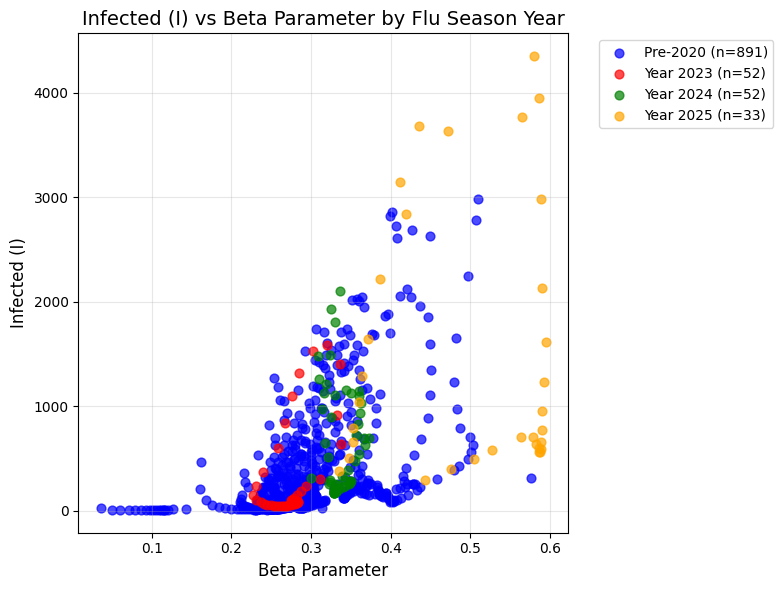

In [175]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 假设已有数据：
I = state_estimates[:, 1]  # 感染人数
beta = param_estimates[:, 0]  # beta参数

# 1. 定义分类掩码
mask_pre2020 = data['flu_season_year'] < 2020
mask_2023 = data['flu_season_year'] == 2023
mask_2024 = data['flu_season_year'] == 2024
mask_2025 = data['flu_season_year'] == 2025

# 2. 创建图形
plt.figure(figsize=(8, 6))

# 3. 绘制散点图（按年份分类）
# <2020 的点（蓝色）
plt.scatter(beta[mask_pre2020], I[mask_pre2020],
           color='blue', alpha=0.7, s=40,
           label=f'Pre-2020 (n={np.sum(mask_pre2020)})')

# 2023 的点（红色）
plt.scatter(beta[mask_2023], I[mask_2023],
           color='red', alpha=0.7, s=40,
           label=f'Year 2023 (n={np.sum(mask_2023)})')

# 2024 的点（绿色）
plt.scatter(beta[mask_2024], I[mask_2024],
           color='green', alpha=0.7, s=40,
           label=f'Year 2024 (n={np.sum(mask_2024)})')

# 2025 的点（橙色）
plt.scatter(beta[mask_2025], I[mask_2025],
           color='orange', alpha=0.7, s=40,
           label=f'Year 2025 (n={np.sum(mask_2025)})')

# 4. 图表优化
plt.xlabel('Beta Parameter', fontsize=12)
plt.ylabel('Infected (I)', fontsize=12)
plt.title('Infected (I) vs Beta Parameter by Flu Season Year', fontsize=14)
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 5. 显示图形
plt.tight_layout()
plt.show()


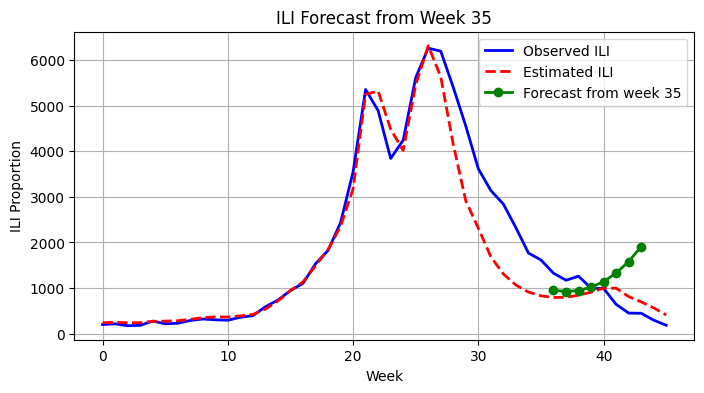

In [176]:
x = 52*22
# visualize_state_estimates(param_estimates[max(x-5,0):52+x], N)
visualize_ili_forecast(obs_data[max(x-5,0):52+x], ILI_estimates[max(x-5,0):52+x], ILI_forecasts[max(x-5,0):52+x], week_to_plot=35, N=10000)

In [177]:

# from datetime import timedelta
# horizon = 8
# df_pred = pd.DataFrame(ILI_forecasts, columns=[f"week_ahead{i}" for i in range(horizon)])
# df_pred['date'] = timedelta(days=7)+ pd.to_datetime(data['date'])

In [178]:
# data_final = pd.read_csv('../data/flu_data_7.csv')
# data_final['date'] = pd.to_datetime(data_final['date'])

In [179]:

# result_dfs = []
# for i in range(horizon):
#     temp_df = pd.DataFrame({
#         'date': df_pred['date'] + timedelta(days=i * 7),
#         'week_ahead': i,  # 第1周、第2周...
#         'point': df_pred[f'week_ahead{i}']/100
#     })
#     result_dfs.append(temp_df)

# final_pred_df = pd.concat(result_dfs, ignore_index=True)

# true_df = data_final[['date', "ILI+"]]

# format_pred_df = pd.merge(
#     final_pred_df,  # 左表（预测值）
#     true_df,  # 右表（真实值）
#     on='date',  # 连接键
#     how='left')
# format_pred_df = format_pred_df.rename(columns={'ILI+': 'true'})

# format_pred_df['date_origin'] = format_pred_df['date'] - format_pred_df['week_ahead'] * timedelta(days=7)
# invalid_dates = format_pred_df.groupby('date').filter(lambda x: (x['true'] <= 1).any())['date'].unique()

# # Filter out those date_origins
# # format_pred_df = format_pred_df[~format_pred_df['date_origin'].isin(invalid_dates)]
# format_pred_df.to_csv('../res/GRU_627_pf.csv', index=False)